### LSTM을 사용한 언어 모델

In [1]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


### 학습을 위한 코드

| 에폭 1 |  반복 1 / 14 | 시간 0[s] | 퍼플렉서티 10000.54
| 에폭 2 |  반복 1 / 14 | 시간 1[s] | 퍼플렉서티 3235.35
| 에폭 3 |  반복 1 / 14 | 시간 3[s] | 퍼플렉서티 1257.87
| 에폭 4 |  반복 1 / 14 | 시간 5[s] | 퍼플렉서티 967.74
| 에폭 5 |  반복 1 / 14 | 시간 7[s] | 퍼플렉서티 838.05
| 에폭 6 |  반복 1 / 14 | 시간 9[s] | 퍼플렉서티 739.98
| 에폭 7 |  반복 1 / 14 | 시간 11[s] | 퍼플렉서티 644.06
| 에폭 8 |  반복 1 / 14 | 시간 12[s] | 퍼플렉서티 588.39
| 에폭 9 |  반복 1 / 14 | 시간 14[s] | 퍼플렉서티 512.53
| 에폭 10 |  반복 1 / 14 | 시간 16[s] | 퍼플렉서티 438.57


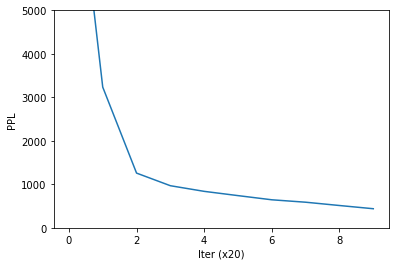

퍼플렉서티 평가 중 ...
162 / 163
테스트 퍼플렉서티:  921.0208034219905


In [8]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 10
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
corpus = corpus[:10000]
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

#기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 5000))

# # 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()